In [21]:
import pandas as pd
import os
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = (15,10)

## Load and pre-process data

### 1) Global parameters

In [2]:
SOURCE_PATH = os.path.dirname(os.getcwd())

TRAIN_SIZE = 0.7 # size of training data (in %)
N_JOBS = 2  # number of jobs to run in parallel
N_SPLITS = 10  # number of splits (k) to be made within the k fold cv
N_ITER = 10  # number of parameter settings that are sampled
SEED = 2294
VERBOSE = True
INPUTS_PATH = os.path.join(SOURCE_PATH, "data", "inputs")
OUTPUTS_PATH = os.path.join(SOURCE_PATH, "data", "outputs")
DATASET_NAMES = ["betadgp_covdgp_data", "betadgp_beta2x2_data", "betadgp_data"]
TARGET_NAME = "betas_dgp"
MODEL_TAG = "FFNN"
STANDARDIZE = True

### 2) Local parameters

In [7]:
DIR_NAMES = os.listdir(os.path.join(INPUTS_PATH))

dgp_name = DIR_NAMES[0]
ds = DATASET_NAMES[0] 

In [25]:
data = pd.read_csv(os.path.join(INPUTS_PATH, dgp_name, ds + ".csv"))
y = data["betas_dgp"].to_numpy()
X = data[["cov_dgp"]].to_numpy()

X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=TRAIN_SIZE)

if STANDARDIZE:
    scaler = StandardScaler()
    X_train_zscore = scaler.fit_transform(X_train)
    X_validation_zscore = scaler.transform(X_validation)

In [26]:
X_train.shape

(15749, 1)

In [27]:
X_validation.shape

(6751, 1)

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

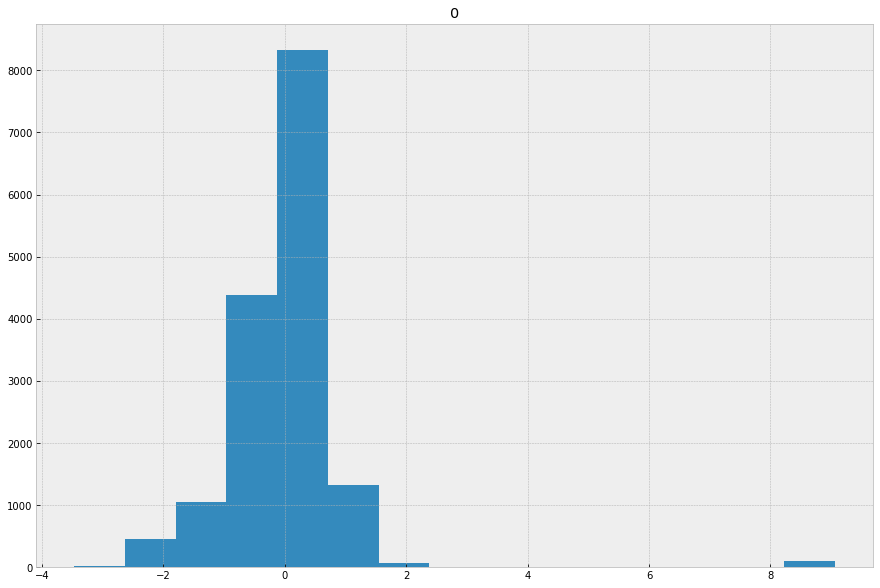

In [28]:
pd.DataFrame(X_train_zscore).hist(bins=15)